"""
Implements an RNN on a synthetic data set, following the architecture 
described in "Deep Knowledge Tracing" by Chris Piech et al.
The RNN implementation is based on min-char-rnn.py by Andrej Karpathy (@karpathy).
BSD License
"""

In [30]:
# Python libraries
import numpy as np
import theano
import theano.tensor as Tensor
import lasagne
import random
import sys
import csv
import time
import matplotlib.pyplot as plt
# allows plots to show inline in ipython notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2

# our own modules
# from utils import *
# from visualize import *

import utils


import visualize

data_sets_map = {
    'synth':"syntheticDetailed/naive_c5_q50_s4000_v0.csv",
    'code_org' : "data/hoc_1-9_binary_input.csv"
}

# DATA_SET = 'code_org'
# DATA_SZ = 500000
DATA_SET = 'synth'

# if DATA_SZ = -1, use entire data set
DATA_SZ = 512
# DATA_SZ = -1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
# hyperparameters
hidden_size = 200 # size of hidden layer of neurons
learning_rate = 3e-2
lr_decay = 1.0
reg_strength = 0.0
grad_clip = 100
batchsize = 64
num_epochs = 2

In [19]:
# Read in the data set
# This function can be moved to utils.py
data_array = np.array(list(csv.reader(open(data_sets_map[DATA_SET],"rb"),delimiter=','))).astype('int')
if DATA_SZ != -1:
    data_array = data_array[:DATA_SZ]
num_samples = data_array.shape[0]
num_problems = data_array.shape[1]

# time steps is number of problems - 1 because we cannot predict on the last problem.
num_timesteps = num_problems - 1 

# Split data into train and test (half and half)

train_data = data_array[0:num_samples/2,:]
val_data =  data_array[num_samples/2:3*num_samples/4,:]
test_data = data_array[3*num_samples/4:num_samples,:]

In [12]:
# code to see how many percent is correct
# print (num_problems)
# for prob in xrange(num_problems):
#     print ('Train Prob {} : percent correct {}'.format(prob, np.mean(train[:,prob]) ))
#     print ('Test Prob {} : percent correct {}'.format(prob, np.mean(test[:,prob]) ))
# print ('Train : percent correct {}'.format( np.mean(train) ))


In [20]:
num_train = train_data.shape[0]
num_test = test_data.shape[0]

print('Vectorization...')
X_train, next_problem_train, truth_train = utils.vectorize_data(train_data)
X_val, next_problem_val, truth_val = utils.vectorize_data(val_data)
X_test, next_problem_test, truth_test = utils.vectorize_data(test_data)
print ("Vectorization done!")
print X_train.shape
print X_val.shape
print X_test.shape

Vectorization...
Vectorization done!
(256, 49, 100)
(128, 49, 100)
(128, 49, 100)


In [21]:
theano.config.optimizer='fast_compile'
theano.config.exception_verbosity='high'

In [22]:
'''
Create a model using Lasagne layering system. The layers are as follows:
 - Input layer: [n_sample, n_time, n_input] -> [n_sample, n_time, n_input]
 - LSTM layer: [n_sample, n_time, n_input] -> [n_sample, n_time, n_hidden]
 - Reshape layer: [n_sample, n_time, n_hidden] -> [n_sample*n_time, n_hidden]
 - Dense layer: [n_sample*n_time, n_hidden] -> [n_sample*n_time, n_output]
 - Output reshape layer: [n_sample*n_time, n_output] -> [n_sample, n_time, n_output]
'''
l_in = lasagne.layers.InputLayer(shape=(None, num_timesteps, num_problems * 2))
l_lstm = lasagne.layers.LSTMLayer(
    l_in, hidden_size, grad_clipping=grad_clip,
    nonlinearity=lasagne.nonlinearities.tanh)
l_reshape = lasagne.layers.ReshapeLayer(l_lstm, (-1, hidden_size))
l_out = lasagne.layers.DenseLayer(l_reshape,
    num_units=num_problems,
    W = lasagne.init.Normal(),
    nonlinearity=lasagne.nonlinearities.sigmoid)
l_pred = lasagne.layers.ReshapeLayer(l_out, (-1, num_timesteps, num_problems))

''' pred:for each student, a vector that gives probability of next question being answered correctly
    y: for each student, a one-hot-encoding of shape (num_timesteps, num_problems), indicating which problem the student will do at the next timestep 
    truth: for each student, a vector that indicates for each timestep whether next problem was answered correctly
'''
pred = lasagne.layers.get_output(l_pred)
next_problem = Tensor.tensor3('next_problem')
truth = Tensor.imatrix("truth")

# pred_probs: shape(num_samples, num_timesteps)
# we reduce the three-dimensional probability tensor to two dimensions
# by only keeping the probabilities corresponding to the next problem
# we don't care about the predicted probabilities for other problems
pred_probs = Tensor.sum(pred * next_problem, axis = 2)
# loss function
loss = Tensor.nnet.binary_crossentropy(pred_probs, truth)

# TODO: why do we use both cost and loss? (naming :D)
# take average of loss per sample, makes loss more comparable when batch sizes change
cost = loss.mean()

# update function
print("Computing updates ...")
all_params = lasagne.layers.get_all_params(l_pred)
updates = lasagne.updates.adam(cost, all_params, learning_rate)

# Function to compute accuracy:
# if probability was > 0.5, we consider it a 1, and 0 otherwise.
# binary_pred: for each student, a vector of length num_timesteps indicating whether the 
# probability of getting the next problem correct is larger than 0.5.
binary_pred = Tensor.round(pred_probs)
acc = Tensor.mean(Tensor.eq(binary_pred, truth))
    
# training function
print("Compiling functions ...")
# training function, only returns loss
train_fn = theano.function([l_in.input_var, next_problem, truth], cost, updates=updates, allow_input_downcast=True)
# training function, returns loss and acc
train_acc_fn = theano.function([l_in.input_var, next_problem, truth], [cost, acc], updates=updates, allow_input_downcast=True)

compute_cost = theano.function([l_in.input_var, next_problem, truth], cost, allow_input_downcast=True)
# computes loss and accuracy
compute_cost_acc = theano.function([l_in.input_var, next_problem, truth], [cost, acc], allow_input_downcast=True)

print("Compiling done!")

Computing updates ...
Compiling functions ...
Compiling done!


In [31]:
# Training!!!
print("Starting training...")
# We iterate over epochs:
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0.0
    train_acc = 0.0
    train_batches = 0
    start_time = time.time()
    for batch in utils.iterate_minibatches(X_train, next_problem_train, truth_train, batchsize, shuffle=False):
        X_, next_problem_, truth_ = batch
        err, acc = train_acc_fn(X_, next_problem_, truth_)
        train_err += err
        train_acc += acc
        train_batches += 1
    train_accuracies.append(train_acc)
    train_loss = train_err/train_batches
    train_losses.append(train_loss)
    
    # And a full pass over the validation data:
    val_err = 0.0
    val_acc = 0.0
    val_batches = 0
    for batch in utils.iterate_minibatches(X_val, next_problem_val, truth_val, batchsize, shuffle=False):
        X_, next_problem_, truth_ = batch
        err, acc = compute_cost_acc(X_, next_problem_, truth_)
        val_err += err
        val_acc += acc
        val_batches += 1
    val_accuracies.append(val_acc)
    val_loss = val_err/val_batches
    val_losses.append(val_loss)

    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss:\t\t{:.6f}".format(train_loss))
    print("  training accuracy:\t\t{:.2f} %".format(train_acc / train_batches * 100))
    print("  validation loss:\t\t{:.6f}".format(val_loss))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc / val_batches * 100))

print("Training completed.")

print("Testing...")
# After training, we compute and print the test error:
test_err = 0
test_acc = 0
test_batches = 0
for batch in utils.iterate_minibatches(X_test, next_problem_test, truth_test, batchsize, shuffle=False):
    X_, next_problem_, truth_ = batch
    err, acc = compute_cost_acc(X_, next_problem_, truth_)
    test_err += err
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test loss:\t\t\t{:.6f}".format(test_err / test_batches))
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

Starting training...
Epoch 1 of 2 took 4.575s
  training loss:		0.711321
  training accuracy:		56.27 %
  validation loss:		0.661220
  validation accuracy:		60.59 %
Epoch 2 of 2 took 3.714s
  training loss:		0.655175
  training accuracy:		61.45 %
  validation loss:		0.672826
  validation accuracy:		61.45 %
Training completed.
Testing...
Final results:
  test loss:			0.676614
  test accuracy:		61.45 %


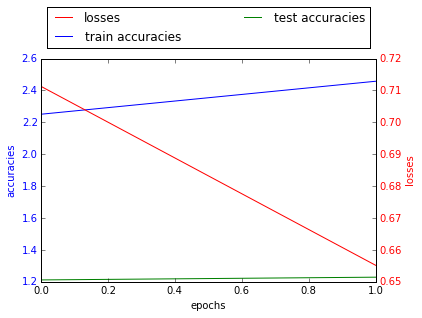

In [33]:
# Visualize the loss and the accuracies for both training and validation sets for each epoch
visualize.plot_loss_acc(DATA_SET + '_train', train_losses, train_accuracies, val_accuracies, learning_rate, reg_strength, num_epochs, num_train)
